## Install, Imports and Helper Functions

In [304]:
!pip install linearmodels
!pip install prince
!pip install mca
!pip install mlxtend
!pip install matplotlib-venn

In [305]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

from scipy import stats
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
from numpy import arange

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import meanabs

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import lightgbm as lgb
import xgboost as xgb
import prince
import mca

In [306]:
# Helper Function
def fix_df(x):
    x['punk_id'] = x['punk_id'].astype('category')
    x['type'] = x['type'].astype('category')
    x['from'] = x['from'].astype(str)
    x['to'] = x['to'].astype(str)
    x['date'] = pd.to_datetime(x['date'], format = '%Y.%m.%d')
    
    x['amount_in_eth'] = x['amount_in_eth'].astype(str)
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('Y', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('Z', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('M', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('T', '')
    x['amount_in_eth'] = x['amount_in_eth'].str.replace('B', '')
    x['amount_in_eth'] = x['amount_in_eth'].replace(',', '', regex=True)
    x['amount_in_eth'] = x['amount_in_eth'].astype(float)

    x['amount_in_dol'] = x['amount_in_dol'].astype(str)
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('Y', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('B', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('T', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('P', '')
    x['amount_in_dol'] = x['amount_in_dol'].str.replace('Z', '')
    x['amount_in_dol'] = x['amount_in_dol'].replace('<', '', regex=True)
    x['amount_in_dol'] = x['amount_in_dol'].replace(',', '', regex=True)
    x['amount_in_dol'] = x['amount_in_dol'].astype(float)
    
    x['amount_in_eth'] = x['amount_in_eth'].fillna(0)
    x['amount_in_dol'] = x['amount_in_dol'].fillna(0)

    return x

def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a contant value equal to the IQR
    times a factor, which, following Tuckey's rule, we set to 1.5 by default
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    Source: https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

# Data Imports

In [307]:
# Read Transactions
file = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/transaction.csv'
df_tr = pd.read_csv(file, header = None, index_col = 0)
df_tr.columns = ['type', 'from', 'to', 'date', 'punk_id', 'amount_in_eth', 'amount_in_dol']
df_tr = df_tr[ ['punk_id'] + [ col for col in df_tr.columns if col != 'punk_id' ] ]
df_tr = fix_df(df_tr)
print('transaction head')
print(df_tr.head())
print()

# Read Accessoires
file2 = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/accessories.csv'
df_acc = pd.read_csv(file2, header = None, sep='\n')
df_acc = df_acc[0].str.split(',', expand=True)
df_acc.drop(0, axis=1, inplace=True)

dict={1:'gender', 
      2:  'acc_1',
      3:'acc_2', 
      4: 'acc_3',
      5:'acc_4',
      6: 'acc_5',
      7:'acc_6',
      8:'acc_7'}
df_acc.rename(columns=dict,
          inplace=True)
print('accessoires head')
print(df_acc.head())
print()

#Read Dummy Encoded Accessoires
file3 = 'https://raw.githubusercontent.com/kalinakalina/DEDA_Cryptopunks/main/data/accessories_transformed_full.csv'
acc = pd.read_csv(file3, index_col = 0)
acc['punk_id'] = acc.index
acc = acc[ ['punk_id'] + [ col for col in acc.columns if col != 'punk_id' ] ]
print('accessoires Dummy Encoded head')
print(acc.head())
print()

transaction head
  punk_id           type      from  ...       date amount_in_eth  amount_in_dol
0                                   ...                                        
0       0  Bid Withdrawn  0x983ace  ... 2021-05-10         250.0      1030000.0
1       0            Bid  0x983ace  ... 2021-04-11         250.0       537615.0
2       0  Bid Withdrawn  0xd7510a  ... 2021-03-03         100.0       160973.0
3       0            Bid  0xd7510a  ... 2021-02-20         100.0       188897.0
4       0  Bid Withdrawn  natealex  ... 2020-09-16          69.0        25532.0

[5 rows x 7 columns]

accessoires head
   gender             acc_1         acc_2       acc_3 acc_4 acc_5 acc_6 acc_7
0  Female  Green Eye Shadow       Earring  Blonde Bob  None  None  None  None
1    Male             Smile        Mohawk        None  None  None  None  None
2  Female         Wild Hair          None        None  None  None  None  None
3    Male         Wild Hair  Nerd Glasses        Pipe  None  None  None

In [308]:
types = df_acc['gender']
types_dummies = pd.get_dummies(types)
types_dummies['punk_id'] = types_dummies.index
types_dummies = types_dummies[ ['punk_id'] + [ col for col in types_dummies.columns if col != 'punk_id' ] ]

# Data Preperation




In [309]:
#Average Sale Price for all Punks
sales = df_tr[df_tr['type'].str.contains("Sold")].reset_index(drop=True)
sales = sales.drop(['from', 'to', 'type', 'amount_in_eth'], axis=1)
sales = sales.groupby(['punk_id'])['amount_in_dol'].mean().reset_index()
sales = sales.fillna(0)
print(sales.info())

## Join accessoires and prices
df = pd.merge(sales, types_dummies, on="punk_id", how='left')
df = pd.merge(df, acc, on="punk_id", how='left')

df = df.set_index(['punk_id'])
df = df.fillna(0)
print(df.head())

y = df['amount_in_dol']
y = y.round(decimals=-2)

X = df.iloc[:,1:]
X = X.astype(int)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   punk_id        10000 non-null  category
 1   amount_in_dol  10000 non-null  float64 
dtypes: category(1), float64(1)
memory usage: 495.9 KB
None
         amount_in_dol  Alien  Ape  ...  Hot Lipstick  Cigarette  Earring
punk_id                             ...                                  
0          1176.000000      0    0  ...           0.0        0.0      1.0
1         13855.666667      0    0  ...           0.0        0.0      0.0
2             0.000000      0    0  ...           0.0        0.0      0.0
3             0.000000      0    0  ...           0.0        0.0      0.0
4             0.000000      0    0  ...           0.0        0.0      1.0

[5 rows x 93 columns]


In [329]:
#Average Sale Price Without Punks that have 0 as average price (unsold)
sales_na = df_tr[df_tr['type'].str.contains("Sold")].reset_index(drop=True)
sales_na = sales_na.drop(['from', 'to', 'type', 'amount_in_eth'], axis=1)
sales_na = sales_na.groupby(['punk_id'])['amount_in_dol'].mean().reset_index()
sales_na.dropna(axis = 0, how='any', inplace=True)

df_na = pd.merge(sales_na, types_dummies, on="punk_id", how='left')
df_na= pd.merge(df_na, acc, on="punk_id", how='left')
df_na = df_na.set_index(['punk_id'])
df_na.fillna(0, inplace=True)

y_na = df_na['amount_in_dol']
y_na = y_na.round(decimals=-2)

X_na = df_na.iloc[:,1:]
X_na = X_na.astype(int)
X_na = sm.add_constant(X_na)

X_na_train, X_na_test, y_na_train, y_na_test = train_test_split(X_na, y_na, test_size=0.3, random_state=0)

In [327]:
sales_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5591 entries, 0 to 9998
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   punk_id        5591 non-null   category
 1   amount_in_dol  5591 non-null   float64 
dtypes: category(1), float64(1)
memory usage: 496.4 KB


# Linear Regression including all data
Trained and tested on data that only non sales that average at 0.

In [311]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_y_pred = lin_model.predict(X_test)

print('Result for Linear Regression \n')
print('Test R^2: ', lin_model.score(X_train, y_train))

print('Adjusted Rsquared Train: ', (1 - (1-lin_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', lin_model.score(X_test, y_test))
print('Adjusted Rsquared Test: ', (1 - (1-lin_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lin_y_pred).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lin_y_pred).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lin_y_pred)).round(decimals=3))

Result for Linear Regression 

Test R^2:  0.18334229627158793
Adjusted Rsquared Train:  0.172
Test R^2:  0.16908332116501912
Adjusted Rsquared Test:  0.142
Mean Absolute Error: 22818.891
Mean Squared Error: 5022102350.887
Root Mean Squared Error: 70866.793


In [312]:
regressor = sm.OLS(y_train, X_train).fit()
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', meanabs(y_test, y_pred))
print('Root Mean Squared Error:', rmse(y_test, y_pred))
print()
print(regressor.summary())

Mean Absolute Error: 22819.137650607194
Root Mean Squared Error: 70866.7418137348

                            OLS Regression Results                            
Dep. Variable:          amount_in_dol   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     17.04
Date:                Tue, 13 Jul 2021   Prob (F-statistic):          5.74e-235
Time:                        17:41:42   Log-Likelihood:                -86324.
No. Observations:                7000   AIC:                         1.728e+05
Df Residuals:                    6908   BIC:                         1.735e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [313]:
tmp = (regressor.pvalues <= 0.05)[1:]
tmp = pd.DataFrame(tmp)
tmp.reset_index(level=0, inplace=True)
tmp.rename(columns={0:'high_sig', 'index': 'attr'}, inplace=True )
sigf = tmp.loc[tmp['high_sig'] == True, 'attr']
print('Coefficients OLS with high significanz \n', sigf)

Coefficients OLS with high significanz 
 0            Alien
1              Ape
2           Female
3             Male
4           Zombie
5           Beanie
7     Pilot Helmet
9      Orange Side
10      Buck Teeth
12        Pigtails
14         Top Hat
40     Cap Forward
41          Hoodie
51      3D Glasses
62            Pipe
65    Small Shades
85    Nerd Glasses
Name: attr, dtype: object


# Linear Regression without avg 0 Sales

In [330]:
lin_model_na = LinearRegression()
lin_model_na.fit(X_na_train, y_na_train)
lin_y_pred_na = lin_model_na.predict(X_na_test)

print('Result for Linear Regression \n')
print('Adjusted Rsquared Train: ', (1 - (1-lin_model_na.score(X_na_train, y_na_train))*(len(y_na_train)-1)/(len(y_na_train)-X_na_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', lin_model_na.score(X_na_test, y_na_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-lin_model_na.score(X_na_test, y_na_test))*(len(y_na_test)-1)/(len(y_na_test)-X_na_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_na_test, lin_y_pred_na).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_na_test, lin_y_pred_na).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_na_test, lin_y_pred_na)).round(decimals=3))

Result for Linear Regression 

Adjusted Rsquared Train:  0.245
Test R^2:  0.235
Adjusted Rsquared Test:  0.191
Mean Absolute Error: 29382.515
Mean Squared Error: 7610172011.909
Root Mean Squared Error: 87236.3


In [315]:
tmp = (regressor.pvalues <= 0.10)[1:]
tmp = pd.DataFrame(tmp)
tmp.reset_index(level=0, inplace=True)
tmp.rename(columns={0:'high_sig', 'index': 'attr'}, inplace=True )
sigf = tmp.loc[tmp['high_sig'] == True, 'attr']
print('Coefficients OLS with high significanz \n', sigf)

Coefficients OLS with high significanz 
 0              Alien
1                Ape
2             Female
3               Male
4             Zombie
5             Beanie
6             Choker
7       Pilot Helmet
9        Orange Side
10        Buck Teeth
12          Pigtails
13     Pink With Hat
14           Top Hat
40       Cap Forward
41            Hoodie
51        3D Glasses
62              Pipe
63                VR
65      Small Shades
80    Classic Shades
84        Big Shades
85      Nerd Glasses
Name: attr, dtype: object


# Linear Regression with Lasso Regularization

In [316]:
opt_model = Lasso(alpha=0.84)
opt_model.fit(X_train, y_train)
lasso_y_pred = opt_model.predict(X_test)

print('Result for LASSO \n')
print('Adjusted Rsquared Train: ', (1 - (1-opt_model.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', opt_model.score(X_test, y_test))
print('Adjusted Rsquared Test: ', (1 - (1-opt_model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, lasso_y_pred).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, lasso_y_pred).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, lasso_y_pred)).round(decimals=3))

opt_model_na = Lasso(alpha=0.84)
opt_model_na.fit(X_na_train, y_na_train)
lasso_y_pred_na = opt_model_na.predict(X_na_test)
print()
print('Result for LASSO without avg 0 sales \n')
print('Adjusted Rsquared Train: ', (1 - (1-opt_model_na.score(X_na_train, y_na_train))*(len(y_na_train)-1)/(len(y_na_train)-X_na_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', opt_model_na.score(X_na_test, y_na_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-opt_model_na.score(X_na_test, y_na_test))*(len(y_na_test)-1)/(len(y_na_test)-X_na_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_na_test, lasso_y_pred_na).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_na_test, lasso_y_pred_na).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_na_test, lasso_y_pred_na)).round(decimals=3))

Result for LASSO 

Adjusted Rsquared Train:  0.172
Test R^2:  0.16931646647199594
Adjusted Rsquared Test:  0.143
Mean Absolute Error: 22812.797
Mean Squared Error: 5020693208.883
Root Mean Squared Error: 70856.85

Result for LASSO without avg 0 sales 

Adjusted Rsquared Train:  0.245
Test R^2:  0.236
Adjusted Rsquared Test:  0.191
Mean Absolute Error: 29385.167
Mean Squared Error: 7608780483.564
Root Mean Squared Error: 87228.324


In [317]:
coeff_df = pd.DataFrame(opt_model_na.coef_, X_na.columns, columns=['Coefficient'])
coeff_df = coeff_df.sort_values(by=['Coefficient'], ascending=False)
print('Coefficients LASSO \n', coeff_df)
coeff_lasso_top_20 = coeff_df.head(20).index

Coefficients LASSO 
                Coefficient
Alien         1.220746e+06
Zombie        1.302557e+05
Ape           9.114466e+04
Orange Side   5.793707e+04
3D Glasses    4.435628e+04
...                    ...
Police Cap   -9.715572e+03
Headband     -9.881030e+03
Bandana      -1.035325e+04
Male         -1.101543e+04
Medical Mask -1.822191e+04

[93 rows x 1 columns]


# Step Wise Regression

In [ ]:
sfs = SFS(LinearRegression(),
           forward=True, 
          k_features='best',
           floating=False, 
           scoring='r2',
           cv=3)

sfs = sfs.fit(X_train, y_train)
print('best combination (r2: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_names_))
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with best number of features (w. StdDev)')
plt.grid()
plt.show()
sfs.subsets_

best combination (r2: 0.088): ('Male', 'Zombie', 'Orange Side', 'Pigtails', 'Top Hat', 'Wild Blonde', 'Smile', 'Hoodie', '3D Glasses', 'Knitted Cap')



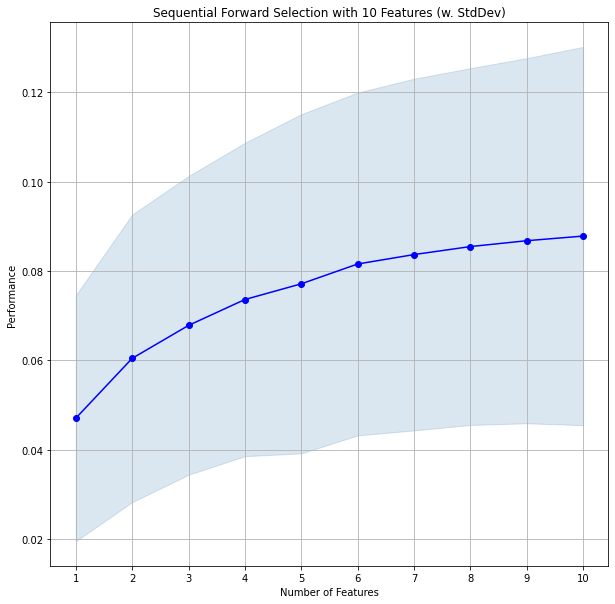

best combination (r2: 0.093): ('Male', 'Zombie', 'Orange Side', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Cowboy Hat', 'Wild Blonde', 'Purple Hair', 'Smile', 'Hoodie', 'Blue Eye Shadow', '3D Glasses', 'Headband', 'Knitted Cap', 'Stringy Hair', 'Shadow Beard', 'Horned Rim Glasses', 'Black Lipstick')



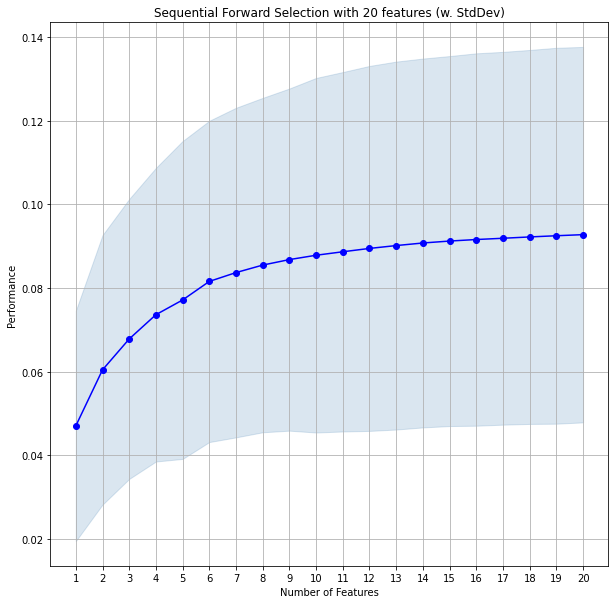

best combination (r2: 0.095): ('Male', 'Zombie', 'Orange Side', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Cowboy Hat', 'Wild Blonde', 'Clown Hair Green', 'Straight Hair', 'Silver Chain', 'Purple Hair', 'Medical Mask', 'Police Cap', 'Clown Nose', 'Smile', 'Hoodie', 'Purple Eye Shadow', 'Blue Eye Shadow', '3D Glasses', 'Shaved Head', 'Headband', 'Knitted Cap', 'Mohawk', 'Stringy Hair', 'Shadow Beard', 'Horned Rim Glasses', 'Black Lipstick', 'Mole')



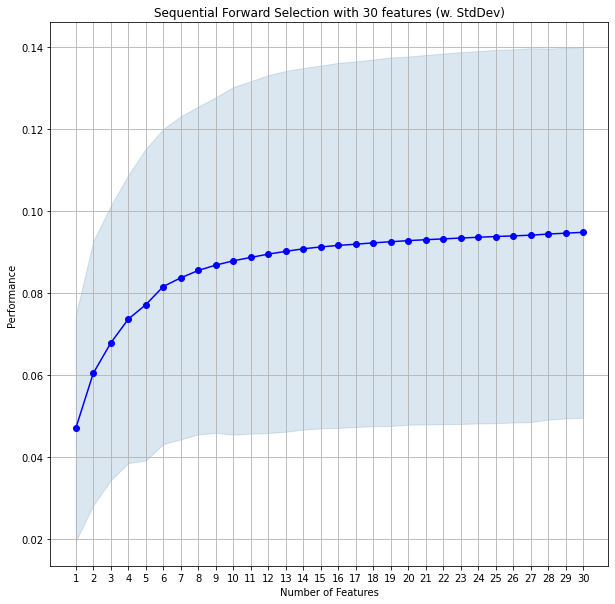

best combination (r2: 0.095): ('Male', 'Zombie', 'Orange Side', 'Buck Teeth', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Cowboy Hat', 'Wild Blonde', 'Clown Hair Green', 'Straight Hair', 'Silver Chain', 'Purple Hair', 'Medical Mask', 'Police Cap', 'Clown Nose', 'Smile', 'Hoodie', 'Purple Eye Shadow', 'Blue Eye Shadow', '3D Glasses', 'Shaved Head', 'Headband', 'Knitted Cap', 'Mohawk', 'Stringy Hair', 'Shadow Beard', 'Horned Rim Glasses', 'Black Lipstick', 'Mole')



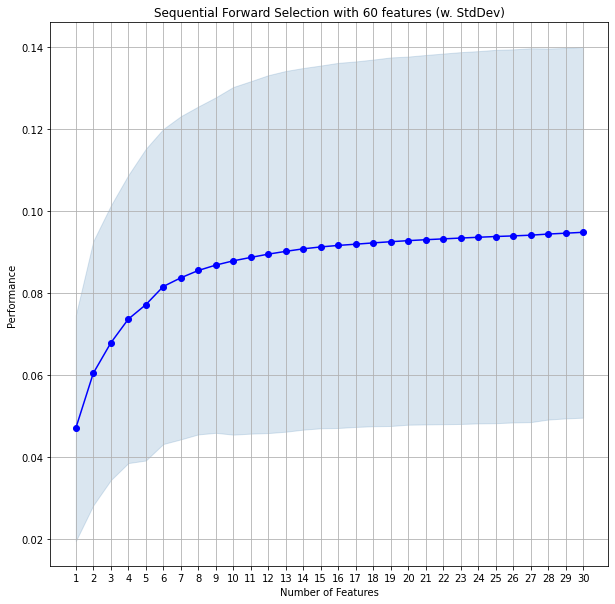

In [319]:
#10 features
sfs2 = SFS(LinearRegression(),
           forward=True, 
          k_features=10,
           floating=False, 
           scoring='r2',
           cv=3)

sfs2 = sfs2.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfs2.k_score_, sfs2.k_feature_names_))

fig2 = plot_sfs(sfs2.get_metric_dict(), kind='std_err')


plt.title('Sequential Forward Selection with 10 Features (w. StdDev)')
plt.grid()
plt.show()

# 20 features
sfsback_20= SFS(LinearRegression(),
           forward=True, 
          k_features=20,
           floating=False, 
           scoring='r2',
           cv=3)

sfsbackfit_20 = sfsback_20.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfsbackfit_20.k_score_, sfsbackfit_20.k_feature_names_))
fig_20 = plot_sfs(sfsbackfit_20.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 20 features (w. StdDev)')
plt.grid()
plt.show()

# 30 features
sfsback = SFS(LinearRegression(),
           forward=True, 
          k_features=30,
           floating=False, 
           scoring='r2',
           cv=3)

sfsbackfit = sfsback.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfsbackfit.k_score_, sfsbackfit.k_feature_names_))

fig2 = plot_sfs(sfsbackfit.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 30 features (w. StdDev)')
plt.grid()
plt.show()

# 60 features
sfsback = SFS(LinearRegression(),
           forward=True, 
          k_features=60,
           floating=False, 
           scoring='r2',
           cv=3)

sfs = sfs.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfsbackfit.k_score_, sfsbackfit.k_feature_names_))
fig2 = plot_sfs(sfsbackfit.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 60 features (w. StdDev)')
plt.grid()
plt.show()

best combination (r2: -27929.002): ('Male', 'Choker', 'Orange Side', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Wild Blonde', 'Straight Hair Blonde', 'Clown Hair Green', 'Gold Chain', 'Police Cap', 'Smile', 'Hoodie', 'Chinstrap', '3D Glasses', 'VR', 'Headband', 'Mohawk Thin', 'Stringy Hair', 'Nerd Glasses')



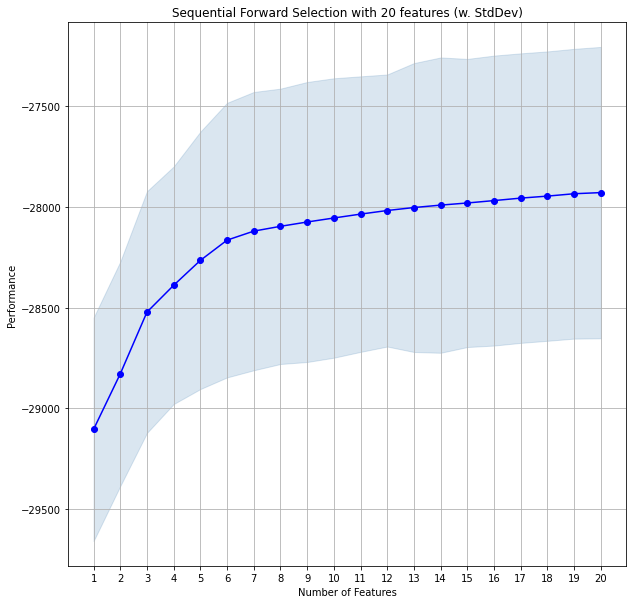

<Figure size 720x720 with 0 Axes>

In [320]:
# 20 features
sfsback_20= SFS(LinearRegression(),
           forward=True, 
          k_features=20,
           floating=False, 
           scoring='neg_mean_absolute_error',
           cv=3)

sfsbackfit_20 = sfsback_20.fit(X_na_train, y_na_train)
print('best combination (r2: %.3f): %s\n' % (sfsbackfit_20.k_score_, sfsbackfit_20.k_feature_names_))
fig_20 = plot_sfs(sfsbackfit_20.get_metric_dict(), kind='std_err')
plt.title('Sequential Forward Selection with 20 features (w. StdDev)')
plt.grid()
plt.show()

# Picture Export
# print('best combination (r2: %.3f): %s\n' % (sfsbackfit_20.k_score_, sfsbackfit_20.k_feature_names_))
# fig_20 = plot_sfs(sfsbackfit_20.get_metric_dict(), kind='std_err')
# plt.title('Sequential Forward Selection with 20 features (w. StdDev)')
# plt.grid()
# plt.show()
plt.savefig('foward_selection')

#Visualization Feature Selection

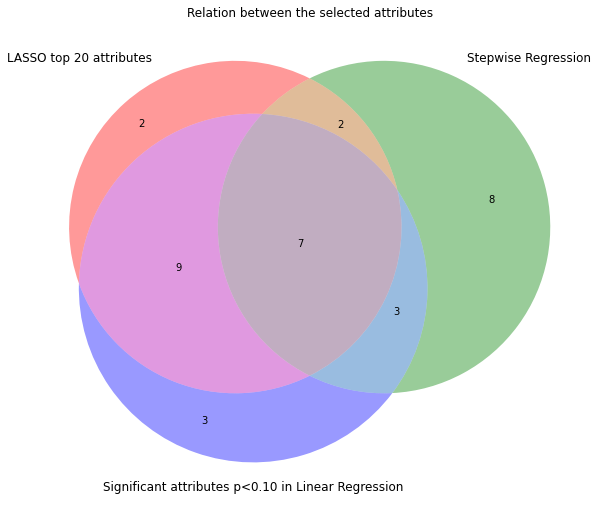

<Figure size 720x720 with 0 Axes>

In [321]:
set1 = set(coeff_lasso_top_20)
set2 = set(sfsbackfit_20.k_feature_names_)
set3 = set(sigf)
venn3([set1, set2, set3], ('LASSO top 20 attributes', 'Stepwise Regression', 'Significant attributes p<0.10 in Linear Regression'))
plt.title('Relation between the selected attributes')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()
plt.savefig('venn_diagram')

In [322]:
print(coeff_lasso_top_20)
print(sfsbackfit_20.k_feature_names_)
print(sigf)

Index(['Alien', 'Zombie', 'Ape', 'Orange Side', '3D Glasses', 'Top Hat',
       'Hoodie', 'Pigtails', 'Pipe', 'Small Shades', 'Choker', 'Pilot Helmet',
       'Wild Blonde', 'Cap Forward', 'Buck Teeth', 'Smile', 'Purple Hair',
       'Pink With Hat', 'Beanie', 'Silver Chain'],
      dtype='object')
('Male', 'Choker', 'Orange Side', 'Pigtails', 'Pink With Hat', 'Top Hat', 'Wild Blonde', 'Straight Hair Blonde', 'Clown Hair Green', 'Gold Chain', 'Police Cap', 'Smile', 'Hoodie', 'Chinstrap', '3D Glasses', 'VR', 'Headband', 'Mohawk Thin', 'Stringy Hair', 'Nerd Glasses')
0              Alien
1                Ape
2             Female
3               Male
4             Zombie
5             Beanie
6             Choker
7       Pilot Helmet
9        Orange Side
10        Buck Teeth
12          Pigtails
13     Pink With Hat
14           Top Hat
40       Cap Forward
41            Hoodie
51        3D Glasses
62              Pipe
63                VR
65      Small Shades
80    Classic Shades
84      

# LGBM Regessor Gradient Boosting
Trained an testes on data that only has non null sales

In [323]:
lgb_model = lgb.LGBMRegressor(
    boosting_type= 'gbdt', 
    num_leaves=42, 
    n_estimators=100,
)
lgb_model.fit(X_na_train, y_na_train)
lgb_y_pred = lgb_model.predict(X_na_test)

print('Result for LGB \n')

print('Adjusted Rsquared Train: ', (1 - (1-lgb_model.score(X_na_train, y_na_train))*(len(y_na_train)-1)/(len(y_na_train)-X_na_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', lgb_model.score(X_na_test, y_na_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-lgb_model.score(X_na_test, y_na_test))*(len(y_na_test)-1)/(len(y_na_test)-X_na_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_na_test, lgb_y_pred).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_na_test, lgb_y_pred).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_na_test, lgb_y_pred)).round(decimals=3))

Result for LGB 

Adjusted Rsquared Train:  0.221
Test R^2:  -0.006
Adjusted Rsquared Test:  -0.065
Mean Absolute Error: 28676.554
Mean Squared Error: 10009730254.092
Root Mean Squared Error: 100048.639


# Linear Regression without avg 0 sales and with outlier truncation

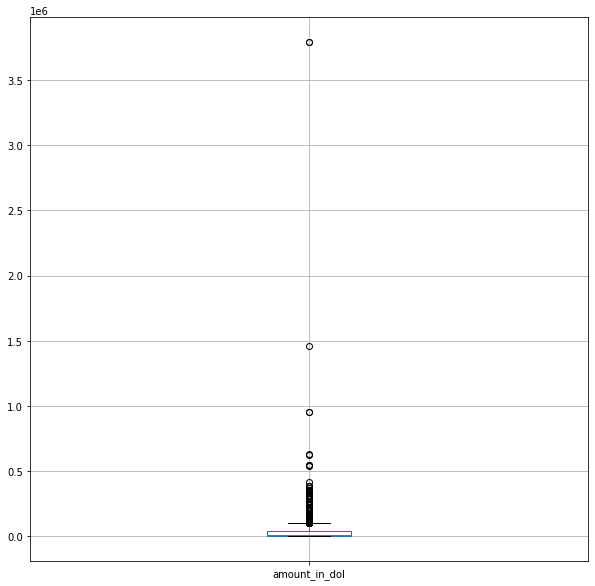

In [324]:
sales = df_tr[df_tr['type'].str.contains("Sold")].reset_index(drop=True)
sales = sales.drop(['from', 'to', 'type', 'amount_in_eth'], axis=1)
sales = sales.groupby(['punk_id'])['amount_in_dol'].mean().reset_index()
sales.dropna(axis = 0, how='any', inplace=True)
sales.boxplot()

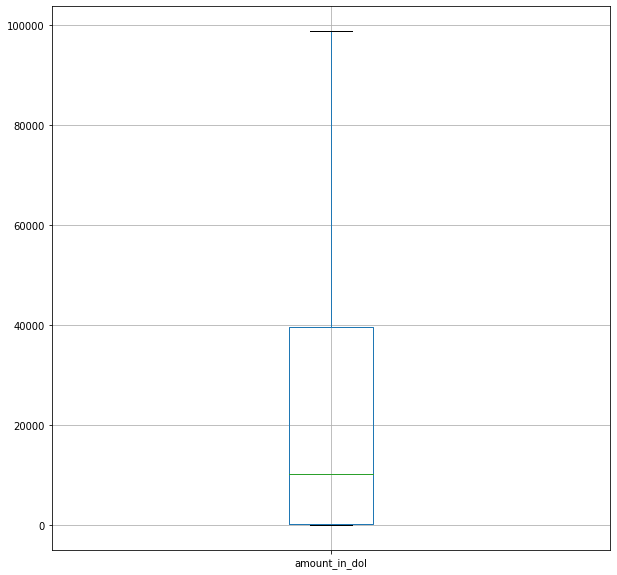

In [325]:
sales.amount_in_dol = outlier_truncation(sales.amount_in_dol)
sales.boxplot()

In [326]:
## Join accessoires and prices
df_na = pd.merge(sales, types_dummies, on="punk_id", how='left')
df_na= pd.merge(df_na, acc, on="punk_id", how='left')
df_na = df_na.set_index(['punk_id'])
df_na.fillna(0, inplace=True)
y = df_na['amount_in_dol']
y = y.round(decimals=-2)

X = df_na.iloc[:,1:]
X = X.astype(int)

X = sm.add_constant(X)

X_na_train, X_na_test, y_na_train, x_na_test = train_test_split(X, y, test_size=0.3, random_state=0)

lin_model_na = LinearRegression()
lin_model_na.fit(X_na_train, y_na_train)
lin_y_pred_na = lin_model_na.predict(X_na_test)

print('Result for Linear Regression with outlier truncation \n')
print('Adjusted Rsquared Train: ', (1 - (1-lin_model_na.score(X_na_train, y_na_train))*(len(y_na_train)-1)/(len(y_na_train)-X_na_train.shape[1]-1)).round(decimals=3))
print('Test R^2: ', lin_model_na.score(X_na_test, y_na_test).round(decimals=3))
print('Adjusted Rsquared Test: ', (1 - (1-lin_model_na.score(X_na_test, y_na_test))*(len(y_na_test)-1)/(len(y_na_test)-X_na_test.shape[1]-1)).round(decimals=3))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_na_test, lin_y_pred_na).round(decimals=3))
print('Mean Squared Error:', metrics.mean_squared_error(y_na_test, lin_y_pred_na).round(decimals=3))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_na_test, lin_y_pred_na)).round(decimals=3))

Result for Linear Regression with outlier truncation 

Adjusted Rsquared Train:  0.107
Test R^2:  0.013
Adjusted Rsquared Test:  -0.045
Mean Absolute Error: 26891.497
Mean Squared Error: 9828764099.824
Root Mean Squared Error: 99140.124
